In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('cork_property_prices*.csv')], ignore_index = True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [9]:
print("Number of rows before dedupes:,", len(df))
df = df.drop_duplicates(subset='listing_id', keep='last') # Dedup on listing_id and keep first record.
print("Number of rows after dedupes:,", len(df))
print("Number of unique properties: ", df.listing_id.nunique())

Number of rows before dedupes:, 2107
Number of rows after dedupes:, 291
Number of unique properties:  291


In [10]:
# Clean data
df['cost'] = df['cost'].str.replace(",","") # Remove commas in cost column
df = df[(df.cost.str.isnumeric() == True)] # Remove rows with alpha characters
df['cost'] = pd.to_numeric(df['cost'])
df['cost'] = df['cost']/1000

# Create an ordinal equivalent of BER
df['ber'] = pd.Categorical(df['ber'])
df['ber_ord'] = df.ber.cat.codes

In [12]:
#df
#df.describe()
df.shape
#df.info()

(280, 11)

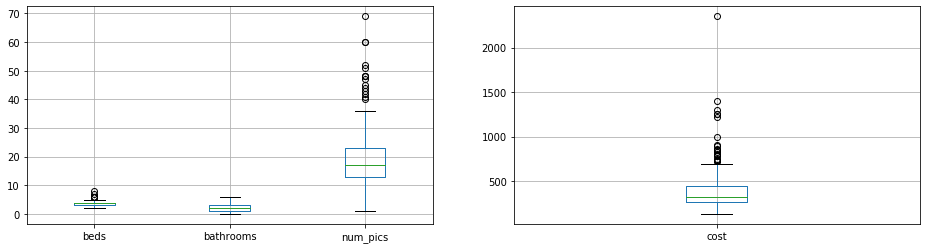

In [13]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.tight_layout()
plt.subplot(1, 2, 1)
pd.DataFrame(df,columns=["beds","bathrooms","num_pics"]).boxplot()
plt.subplot(1, 2, 2)
pd.DataFrame(df,columns=["cost"]).boxplot()

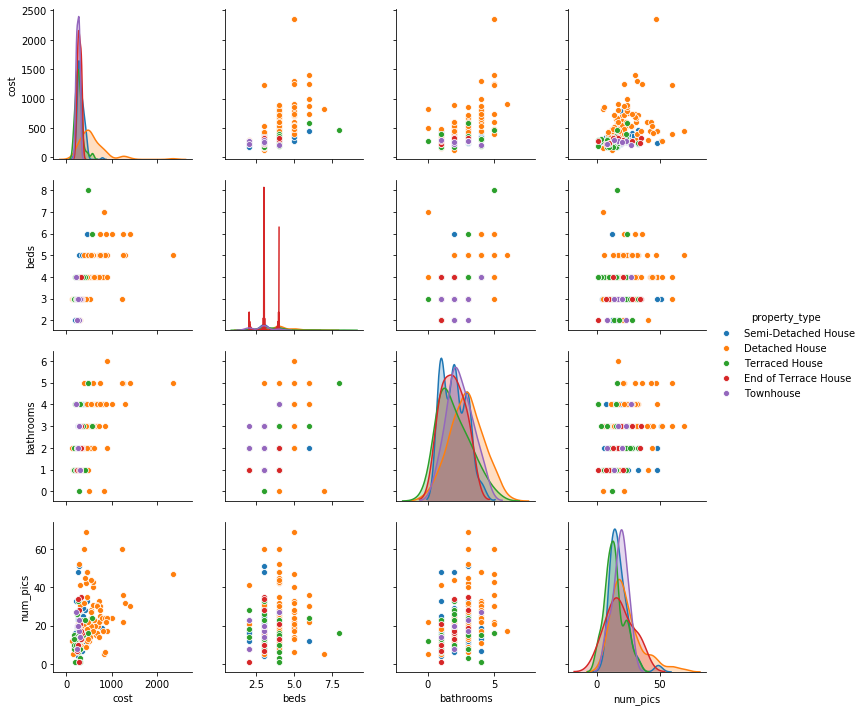

In [14]:
# Basic correlogram
sns.pairplot(df
             ,vars=["cost", "beds", "bathrooms", "num_pics"]
             #,kind="reg"
             ,hue="property_type"
            )
plt.show()

In [16]:
# Explore data by location
#df.plot.line(data=df["beds","cost"], x="beds", y="cost")
#df[["beds","cost","location"]].groupby('location','beds').plot(x="beds", y="cost")
df.groupby(['location', 'beds'])['cost'].agg(['count','mean'])
filter1 = df['property_type']=='Semi-Detached House'
#filter2 = df['location'].isin(['douglas','model-farm-road','bishopstown','blackrock','glasheen'])
filter3 = df['beds']==3
filtered = df[filter1 & filter3]
filtered.groupby(['location','property_type','beds'])['cost'].agg(['count','mean']).sort_values('mean',ascending=False)


,,,count,mean
location,property_type,beds,,
model-farm-road,Semi-Detached House,3,3,381.666667
ballintemple,Semi-Detached House,3,4,342.500000
bishopstown,Semi-Detached House,3,2,342.500000
blackrock,Semi-Detached House,3,3,330.000000
rochestown,Semi-Detached House,3,5,328.000000
glasheen,Semi-Detached House,3,9,326.000000
wilton,Semi-Detached House,3,2,325.000000
ballinlough,Semi-Detached House,3,6,305.833333
lehenaghmore,Semi-Detached House,3,4,281.250000


## Feature Engineering
The data needs some manipulation to be optimal for modeling. Changes we'll make:

1. 1-hot encode categorical variables for use in linear models.
2. Create a continuous equivalent of the BER categorical variable. 
3. Create a binary variable that indicates if the house is named or numbers. Intuition is that numbered houses are less valuable.


In [17]:
# Create 1-hot encodings for property_type and location variables.
loc_vars = pd.get_dummies(df.location, prefix = 'loc')
type_vars = pd.get_dummies(df.property_type, prefix = 'type')
df = pd.concat([df,loc_vars,type_vars], axis=1)
df.shape

(280, 28)

In [18]:
df.ber.isnull().describe()

count       280
unique        2
top       False
freq        237
Name: ber, dtype: object

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280 entries, 644 to 2106
Data columns (total 28 columns):
address                      277 non-null object
bathrooms                    280 non-null int64
beds                         280 non-null int64
ber                          237 non-null category
cost                         280 non-null float64
listing_id                   280 non-null int64
location                     280 non-null object
num_pics                     280 non-null int64
property_type                280 non-null object
url                          60 non-null object
ber_ord                      280 non-null int8
loc_ballincollig             280 non-null uint8
loc_ballinlough              280 non-null uint8
loc_ballintemple             280 non-null uint8
loc_bishopstown              280 non-null uint8
loc_blackrock                280 non-null uint8
loc_carrigaline              280 non-null uint8
loc_douglas                  280 non-null uint8
loc_glasheen         

In [20]:
# 75:25 train:test split.
from sklearn.model_selection import train_test_split
df = df.drop(['listing_id','location','address','property_type','ber'], axis=1)
train, test = train_test_split(df, test_size=0.2)
x = train.drop('cost', axis=1)
y = train.cost

# Train model
reg = linear_model.LinearRegression()
#x = train[['beds','bathrooms','num_pics','ber_ord']]
#x = train.drop()
#y = train['cost']
reg.fit(x,y)
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

ValueError: could not convert string to float: '/cork/houses-for-sale/carrigaline/7-kingswood-waterpark-carrigaline-cork-2355909/'

In [ ]:
y_true = test.cost
y_pred = reg.predict(test.drop('cost', axis=1))
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: %f" % (rmse))
print("MSE: ", mean_squared_error(y_true, y_pred))
print("Mean Absolute Error: %f" % mean_absolute_error(y_true,y_pred))
print("R2: ", r2_score(y_true,y_pred))

In [ ]:
dir(reg)
coeff_df = pd.DataFrame(reg.coef_, x.columns, columns=['Coefficient'])  
coeff_df

In [ ]:
num_vars = df[['beds','bathrooms','num_pics']]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(num_vars.values, i) for i in range(num_vars.shape[1])]
vif["features"] = num_vars.columns
vif

In [ ]:
dir(reg)

In [ ]:
# For analysis purpose run entire set through linear model
x = df.drop('cost', axis=1)
y = df.cost

reg = linear_model.LinearRegression()
reg.fit(x,y)
coeff_df = pd.DataFrame(reg.coef_, x.columns, columns=['Coefficient'])  

print('Intercept: \n', reg.intercept_)
coeff_df

In [ ]:
df.head